# Segmentación de Empleados de la Contraloría General de la República Dominicana en el 2021

**Objetivo:** Identificar grupos naturales de empleados según sueldo, estatus, función y departamento

**Autores:** Scarlet Abreu y Renso Peralta

#### Importar librerías

In [20]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#### Cargar dataset

Se carga el dataser de 'merged_empleados.csv' a la variable df.

In [3]:
df = pd.read_csv("C:\\Users\\Scarlet\\Downloads\\DW_CGR_ETL\\merged_empleados.csv")

#### Mostrar primeras filas y resumen estadístico

En esta parte se muestran las primeras 5 filas del dataset y se muestra un resumen estadístico.

In [27]:
print("Primeras filas del dataset:")
print(df.head())
print("\nResumen estadístico:")
print(df.describe())
print("\nInformación general:")
print(df.info())
print("\nValores nulos:")
print(df.isnull().sum())
print("\nNúmero de empleados únicos:")
print(df['EMPLEADO_ID'].nunique())

Primeras filas del dataset:
   EMPLEADO_ID  DEPARTAMENTO_ID  FUNCION_ID  ESTATUS_ID  MES_ID    SUELDO  \
0            1                1           1           1       1   45000.0   
1            2                1           2           2       1  150000.0   
2            3                1           3           1       1  100000.0   
3            4                1           4           2       1   90000.0   
4            5                1           1           1       1   45000.0   

                   NOMBRE_EMPLEADO  EDAD       SEXO  \
0             DOMINGO LUISOR ARIAS  48.0  MASCULINO   
1              ERASMO DURAN BELTRE  61.0  MASCULINO   
2       MOHAMED PLACIDO MARMOLEJOS  37.0  MASCULINO   
3          MARTHA NOEMI DIAZ NUÑEZ  52.0   FEMENINO   
4  PEDRO NAPOLEON HERNANDEZ CASADO  58.0  MASCULINO   

                       NOMBRE_DEPARTAMENTO NIVEL_DEPARTAMENTO  \
0  DIRECCION UNIDADES DE AUDITORIA INTERNA               ALTO   
1  DIRECCION UNIDADES DE AUDITORIA INTERNA      

#### Histograma

Los histogramas muestran cómo se distribuyen los valores de sueldo y edad dentro del conjunto de datos, permitiendo identificar rangos comunes y posibles valores fuera de lo normal. La curva KDE ayuda a visualizar la forma general de la distribución.

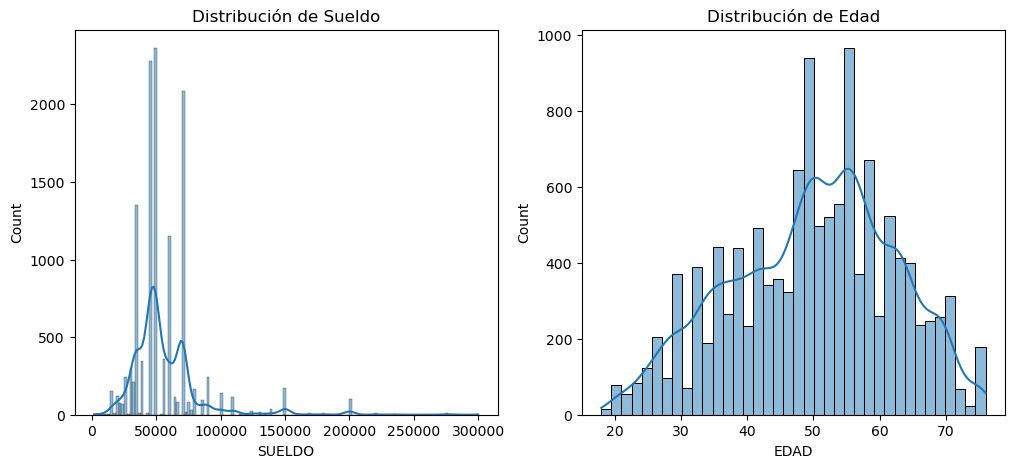

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['SUELDO'], kde=True, ax=axs[0])
axs[0].set_title('Distribución de Sueldo')
sns.histplot(df['EDAD'], kde=True, ax=axs[1])
axs[1].set_title('Distribución de Edad')
plt.show()

#### Matríz de correlación

La matriz de correlación revela la intensidad de la relación entre las variables numéricas del dataset. Este análisis facilita identificar qué variables están más asociadas entre sí para futuros modelos o decisiones analíticas.

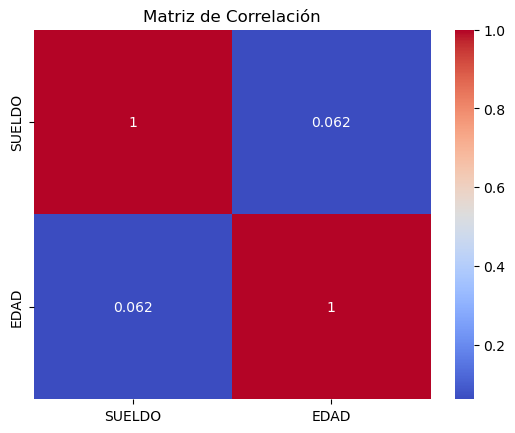

In [22]:
corr = df[['SUELDO', 'EDAD']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

#### Variables seleccionadas para clustering

En esta parte se seleccionan las variables a utilizar en el modelo.

In [5]:
variables = ["SUELDO", "EDAD"]
df_model = df[variables].copy()

#### Normalización

En la parte de normalización con StandardScaler transforma todas las variables a las misma escala con media 0 y desviació estándar 1. Esto evita que variables con valores grandes, como el sueldo, dominen el cálculo de distancias en k-means, permitiendo que todas las caracteríticas contributan de manera equilibrada al forma los clusters.

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model)

#### Determinar el número de clusters (K)

En esta parte del modelo, se implementa el método del codo, que ayuda a determinar el número óptimo de clusters para k-means. Se calcula la inercia, que es la suma de las distancias al cuadrado de cada punto a su centroide, para distintos valores de k. Al graficar la inercia contra k, se busca un 'codo' en la curva, el punto donde la disminución de la inercia se vuelve menos pronunciada indica un número de clusters que balancea la cohesión interna y la simpliciadad del modelo.

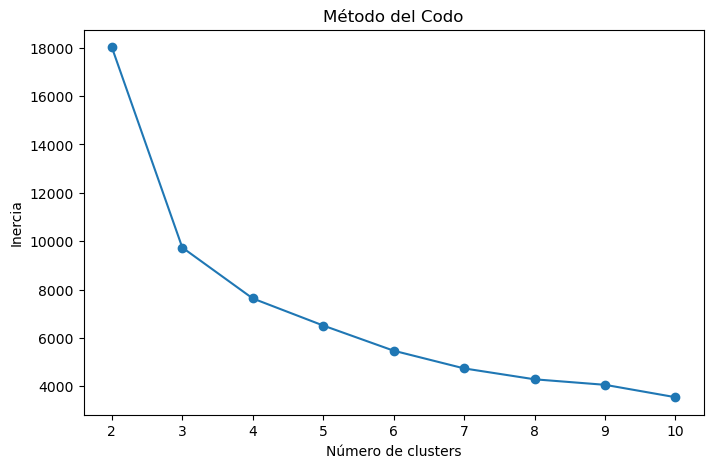

In [15]:
# Método del codo
inertia = []
sil_scores = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.title("Método del Codo")
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")
plt.show()

#### Evaluación de clustering con silhouette score

Este gráfico muestra el puntaje de silueta para distintos valores de k, lo que permite medir qué tan bien separados y cohesionados están los clusters. Valores más altos indican una mejor separación entre grupos, ayudando a elegir el número óptimo de clusters para el modelo.

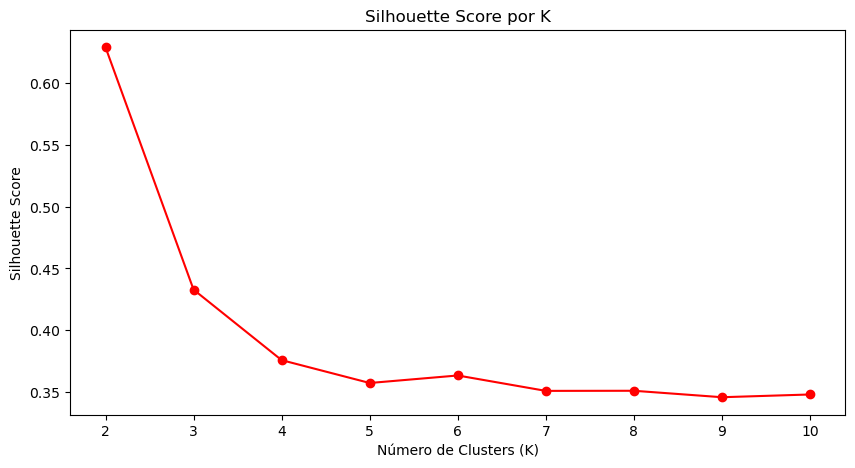

In [16]:
# Gráfico de Silhouette
plt.figure(figsize=(10, 5))
plt.plot(K_range, sil_scores, 'ro-')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score por K')
plt.show()

In [ ]:
Seleccionamos el número de clusters utilizando el coeficiente de Silhouette porque, a diferencia del método del codo, este evalúa simultáneamente la cohesión interna de los grupos y su separación entre sí. Aunque el codo sugería k = 3, la silueta mostró que k = 2 ofrece clusters más compactos, mejor definidos y con menor solapamiento, por lo que representa la opción más adecuada para nuestros datos.

#### Clustering con K-Means

En esta parte se entrena el modelo k-means con un k = 2. La función fit_predict hace dos cosas a la vez, ajusta el modelo a los datos normalizados X_scaled y asigna a cada observación un cluster al que pertenece. El resultado se guarda en la columna 'CLUSTER' de df_model, permitiendo identificar a qué grupo pertenece cada empleado según el sueldo y la edad.

In [23]:
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
df_model['CLUSTER'] = kmeans.fit_predict(X_scaled)

#### Evaluación del clustering

En esta parte se calcula la puntuación silhouette, que mide qué tan bien definidos están os clusters. Toma los datos normalizados, X_scaled, y las etiquetas de cluster, df_model['CLUSTER'], y devuelve un valor entre -1 y

In [24]:
sil_score = silhouette_score(X_scaled, df_model['CLUSTER'])
print(f"Silhouette Score: {sil_score:.3f}")

Silhouette Score: 0.629


Una puntuación de silhouette de 0.629 indica que los clusters son claramente separables y que cada punto está bastante cerca del centro de su propio cluster y lejos de otros clusters. Teniendo en cuenta que el rango de silhouette es:

- **0.0 - 0.25**: Significa que los clusters son débiles y se superponen.
- **0.25 - 0.50**: Significa que los clusters son aceptables, pero con algo de mezcla.
- **0.50 - 0.70**: Significa que los clusters son bien definidos y diferenciados.
- **0.70 - 1.0**: Significa que los clusters son muy fuertes y separados, casi perfectos.

#### Análisis de los resultados

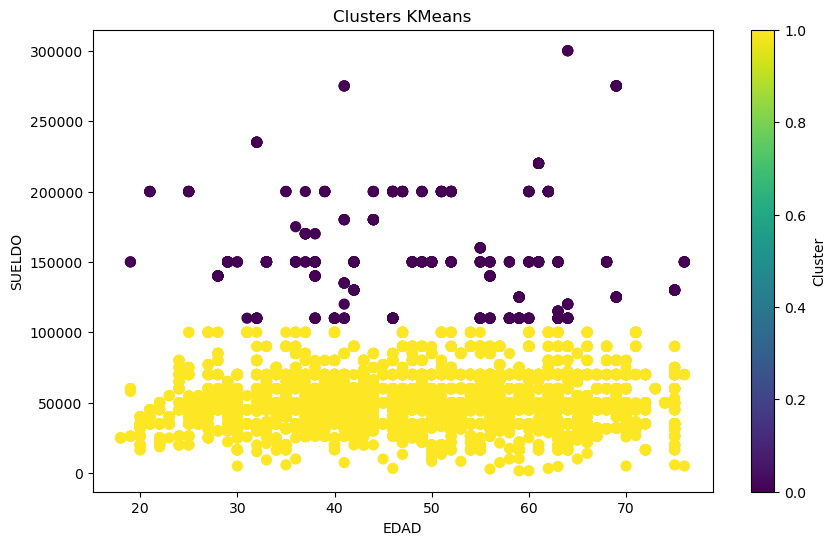

In [25]:
plt.figure(figsize=(10,6))
plt.scatter(df_model['EDAD'], df_model['SUELDO'], c=df_model['CLUSTER'], cmap='viridis', s=50)
plt.xlabel('EDAD')
plt.ylabel('SUELDO')
plt.title('Clusters KMeans')
plt.colorbar(label='Cluster')
plt.show()

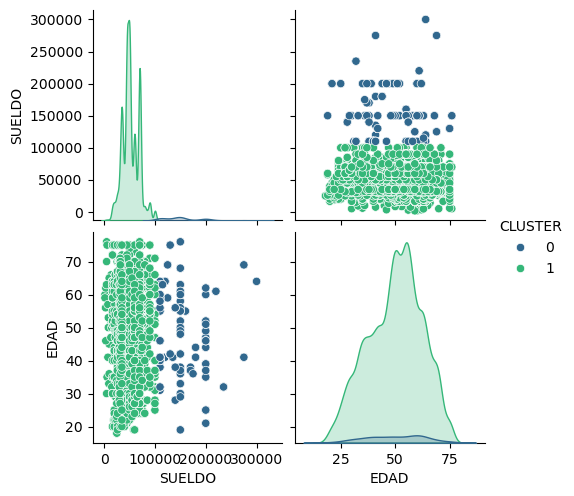

In [26]:
# Pairplot de variables originales por cluster
sns.pairplot(df_model[['SUELDO', 'EDAD', 'CLUSTER']], hue='CLUSTER', palette='viridis')
plt.show()

Este pairplot permite visualizar cómo se relacionan las variables originales sueldo y edad entre sí, diferenciando a los empleados según el cluster al que pertenecen. La gráfica ayuda a identificar patrones, solapamientos o separaciones entre grupos, mostrando si los clusters presentan diferencias claras en estas características numéricas.

#### Conclusión

El modelo de clustering k-means aplicado a los datos de empleados de la Contraloría General de la República Dominicana (CGR), logró identificar dos grupos principales con características similares, principalmente en términos de sueldo y edad. La puntuación de dilhouette de 0.629 indica que los clusters están bien definidos y que los empleados dentro de cada grupo son relativamente homogéneos. Esto sugiere que el algoritmo separó efectivamente los empleados en segmentos coherentes según su perfil laboral y remuneración.